In this notebook, the estimates for the energy consumption of the top 100 mineable cryptocurrencies is calculated. 
In the first section, a hardware based estimation is made. Secondly, a revenue based is made. 
After this, we take a look at the electronic waste by mining. Finally, we investigate the results and check for inter-and extrapollation.

In [116]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [117]:
DATA_PATH = 'data/'
HIST_PATH = DATA_PATH + 'hist/'
HARDWARE_PATH = DATA_PATH+'hardware/'
seconds_in_year = 31536000
hours_in_year = 8760

In [118]:
LOWER_PUE = 1
UPPER_PUE = 1.2
ESTIMATE_PUE = 1.1

Example for one day, historical data is done in results

In [119]:
mineable_100 = pd.read_csv(HIST_PATH+'mineable_100_03-29-2020.csv')
mineable_100[:10]

,Name,#,market_cap,price,tag,algorithm,block_time,difficulty,nethash_scraped,block_reward,exchange_rate,exchange_rate_curr
0,bitcoin,1,"$112,637,095,947","$6,157.28",BTC,SHA-256,628.0000,1.391252e+13,9.514942e+19,12.681600,6122.690000,BTC
1,ethereum,2,"$14,302,393,217",$129.67,ETH,Ethash,13.2139,2.241400e+15,1.696244e+14,2.000000,0.021066,BTC
2,bitcoincash,3,"$3,901,231,254",$212.52,BCH,SHA-256,600.0000,5.402468e+11,0.000000e+00,NaN,NaN,NaN
3,bitcoinsv,4,"$2,858,475,679",$155.74,BSV,SHA-256,585.0000,3.485503e+11,2.558995e+18,12.500000,0.025320,BTC
4,litecoin,5,"$2,474,367,059",$38.43,LTC,Scrypt,140.0000,4.894266e+06,1.501480e+14,12.500000,0.006253,BTC
5,monero,6,"$804,523,074",$45.97,XMR,RandomX,110.0000,1.578298e+11,1.434817e+09,1.801793,0.007469,BTC
6,cardano,7,"$764,962,992",$0.029504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,tron,8,"$749,038,292",$0.011233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,dash,9,"$603,611,050",$64.17,DASH,X11,158.0000,1.529665e+08,4.158139e+15,1.553313,0.010452,BTC
9,ethereumclassic,10,"$582,962,764",$5.01,ETC,Ethash,13.0344,1.307509e+14,1.003122e+13,3.104000,0.000816,BTC


In [120]:
# Clean market cap and price
def clean_int(string):
    return float(string.strip('$').replace(',',''))

def clean_mineable_data(data):
    data = data.set_index('Name')
    data['market_cap'] = data['market_cap'].apply(lambda x:clean_int(x))    
    data['price'] = data['price'].apply(lambda x:clean_int(x))
    return data
mineable_100 = clean_mineable_data(mineable_100)

# Hardware based estimation

In this section we make a first estimation based on the most efficient hardware (found online)

## Function

In [121]:
# Bitcoin forks have the same initial difficulty
bitcoin_forks = ['bitcoin', 'bitcoincash','bitcoinsv','peercoin', 'litecoincash']

In [167]:
def hardware_based_estimation(data):
    """
    Function that calculates upper bound, lower bound and estimate for daily data.
    """
    found_data = data[~data.isnull().any(axis=1)].copy()
    # Fill in original difficulties
    found_data['difficulty_factor'] = found_data.apply(lambda x: difficulty_factor(x), axis=1)
    found_missing_difficulty = found_data[found_data['difficulty_factor']!=0].copy()

    # Calculate nethash
    found_missing_difficulty['nethash_calc'] = found_missing_difficulty['difficulty']*found_missing_difficulty['difficulty_factor']/found_missing_difficulty['block_time'] # amount of hashes per second
    
    # Create dictionairy that maps coins to their profitable hardware
    lower_prof_hardware = dict(found_missing_difficulty.apply(lambda x: create_profitable_set(x, "lower"), axis = 1))
    upper_prof_hardware = dict(found_missing_difficulty.apply(lambda x: create_profitable_set(x, "upper"), axis = 1))
    estimate_prof_hardware = dict(found_missing_difficulty.apply(lambda x: create_profitable_set(x, "estimate"), axis = 1))
    
    # Calculate estimates
    found_missing_difficulty['lower_bound'] = found_missing_difficulty.apply(lambda x: calc_bound(x, lower_prof_hardware, True),axis=1)
    found_missing_difficulty['upper_bound'] = found_missing_difficulty.apply(lambda x: calc_bound(x, upper_prof_hardware, False),axis=1)
    found_missing_difficulty['estimate'] = found_missing_difficulty.apply(lambda x: calc_estimate(x, estimate_prof_hardware),axis=1)
    
    return found_missing_difficulty[['lower_bound','estimate','upper_bound']]

In [123]:
found_data = mineable_100[~mineable_100.isnull().any(axis=1)].copy()

In [124]:
# Functions to go from the nBits to the first hashrate
def hex_to_bits(hex_number):
    if int(hex_number,16) >= 8:
        return 0
    elif int(hex_number,16) >= 4:
        return 1
    elif int(hex_number,16) >= 2:
        return 2
    elif int(hex_number,16) == 1:
        return 3
    else:
        return 4
        
def nBits_to_factor(nBits):
    if nBits[:2] != "0x":
        raise Exception("Wrong format, provide hexadecimal number")
    exp = 8*(int(nBits[:4],16)-3)
    mantisse = nBits[4:]
    i=0
    extra_0 = 0
    while hex_to_bits(mantisse[i]) == 4:
        extra_0 += 4
        i += 1
    extra_0 += hex_to_bits(mantisse[i])
    return 256-exp-4*len(mantisse)+extra_0

In [125]:
def difficulty_factor(coin):
    """
    Enter the difficulty factors used to calculate current hashrate. 
    These values where all found by exploring the first block, documentation or source code. 
    References are kept in separate excell sheet
    """
    if coin.name in bitcoin_forks:
        return 2**32
    if coin.name == 'zcash':
        return 2**13
    if coin.name == 'litecoin' or coin.name == 'monacoin':
        return 2**32
    if coin.name == 'ethereum' or coin.name == 'ethereumclassic':
        return 1
    if coin.name == 'monero':
        return 1 # https://github.com/monero-project/monero/blob/36241552b56b156c08319935baf7afda12deb3c5/src/cryptonote_basic/difficulty.h
    if coin.name == 'dash' or coin.name == 'dogecoin':
        return 2**20
    if coin.name == 'ravencoin':
        return 2**24
    if coin.name == 'horizen':
        return 2**nBits_to_factor("0x1f07ffff")
    if coin.name == 'komodo':
        return 2**nBits_to_factor("0x200f0f0f")
    else:
        return 0

## First web-based trial (OLD)

First, we calculate a lower bound by using only the most efficient hardware

In [126]:
def hardware_hashrate(coin): # Max hashes per second for the hardware
    if coin['algorithm'] == 'SHA-256':
        return 16*10**12
    if coin['algorithm'] == 'Scrypt':
        return 504*10**6
    if coin['algorithm'] == 'Ethash':
        return 190*10**6
    if coin['algorithm'] == 'Equihash':
        return 42*10**3
    return 0

In [127]:
# Energy use in Watts
def hardware_consumption(coin): 
    if coin['algorithm'] == 'SHA-256':
        return 1280
    if coin['algorithm'] == 'Scrypt':
        return 970
    if coin['algorithm'] == 'Ethash':
        return 800
    if coin['algorithm'] == 'Equihash':
        return 760
    return 0

In [128]:
def hardware_consumption_hash(coin): # Joule per hash
    if coin['algorithm'] == 'SHA-256':
        return 0.1/(10**9)
    if coin['algorithm'] == 'Scrypt':
        return 1.6/(10**6) # Antminer L3+ https://www.asicminervalue.com/miners/bitmain/antminer-l3-504mh
    if coin['algorithm'] == 'Ethash':
        return 4/(10**6) # Bitmain Antminer E3 – Ethereum 190 MH/S
    else: 
        return 0

In [129]:
def calc_num_hardware(coin):
    if coin['hardware_hashrate'] == 0:
        return 0
    if coin['nethash_calc'] != 0:
        return coin['nethash_calc']/coin['hardware_hashrate'] 
    else:
        return coin['nethash_scraped']/coin['hardware_hashrate']

In [130]:
found_data['difficulty_factor'] = found_data.apply(lambda x: difficulty_factor(x), axis=1)
found_data['hardware_hashrate'] = found_data.apply(lambda x: hardware_hashrate(x), axis=1)
found_data['hardware_consumption'] = found_data.apply(lambda x: hardware_consumption(x), axis=1)

In [131]:
found_data['nethash_calc'] = found_data['difficulty']*found_data['difficulty_factor']/found_data['block_time'] # amount of hashes per second
found_data['num_hardware'] = found_data.apply(lambda x: calc_num_hardware(x),axis=1)
found_data['energy_per_second'] = found_data['num_hardware']*found_data['hardware_consumption'] # in Watt
found_data['annual_energy'] = found_data['energy_per_second']*8760 # hours in a year
found_data

,#,market_cap,price,tag,algorithm,block_time,difficulty,nethash_scraped,block_reward,exchange_rate,exchange_rate_curr,difficulty_factor,hardware_hashrate,hardware_consumption,nethash_calc,num_hardware,energy_per_second,annual_energy
Name,,,,,,,,,,,,,,,,,,
bitcoin,1,1.126371e+11,6157.280000,BTC,SHA-256,628.0000,1.391252e+13,9.514942e+19,12.681600,6.122690e+03,BTC,4294967296,16000000000000,1280,9.514942e+19,5.946839e+06,7.611954e+09,6.668071e+13
ethereum,2,1.430239e+10,129.670000,ETH,Ethash,13.2139,2.241400e+15,1.696244e+14,2.000000,2.106649e-02,BTC,1,190000000,800,1.696244e+14,8.927599e+05,7.142079e+08,6.256462e+12
bitcoinsv,4,2.858476e+09,155.740000,BSV,SHA-256,585.0000,3.485503e+11,2.558995e+18,12.500000,2.532000e-02,BTC,4294967296,16000000000000,1280,2.558995e+18,1.599372e+05,2.047196e+08,1.793344e+12
litecoin,5,2.474367e+09,38.430000,LTC,Scrypt,140.0000,4.894266e+06,1.501480e+14,12.500000,6.252700e-03,BTC,4294967296,504000000,970,1.501480e+14,2.979126e+05,2.889752e+08,2.531423e+12
monero,6,8.045231e+08,45.970000,XMR,RandomX,110.0000,1.578298e+11,1.434817e+09,1.801793,7.469000e-03,BTC,1,0,0,1.434817e+09,0.000000e+00,0.000000e+00,0.000000e+00
dash,9,6.036110e+08,64.170000,DASH,X11,158.0000,1.529665e+08,4.158139e+15,1.553313,1.045151e-02,BTC,1048576,0,0,1.015171e+12,0.000000e+00,0.000000e+00,0.000000e+00
ethereumclassic,10,5.829628e+08,5.010000,ETC,Ethash,13.0344,1.307509e+14,1.003122e+13,3.104000,8.164000e-04,BTC,1,190000000,800,1.003122e+13,5.279588e+04,4.223671e+07,3.699935e+11
zcash,11,2.870108e+08,29.890000,ZEC,Equihash,75.0000,4.411493e+07,4.818527e+09,5.000000,4.852330e-03,BTC,8192,42000,760,4.818527e+09,1.147268e+05,8.719239e+07,7.638054e+11
dogecoin,12,2.193462e+08,0.001770,DOGE,Scrypt,62.0000,2.369565e+06,1.641485e+14,10000.000000,2.887500e-07,BTC,1048576,504000000,970,4.007531e+10,7.951450e+01,7.712907e+04,6.756506e+08


In [132]:
total_energy_crypto = np.sum(found_data['annual_energy'])
total_energy_crypto_TWh = total_energy_crypto/10**12
total_energy_crypto_TWh

79.39009751714966

In [133]:
total_energy_world_TWh = 19504 # TWh 

In [134]:
total_energy_crypto_TWh/total_energy_world_TWh

0.004070452087630725

0.4% of global electricity

## Hardware profitability threshold

Here we make our estimation more accurate by investigating entire hardware datasets (created in hardware.ipynb).

In [135]:
SHA256_hardware = pd.read_csv(HARDWARE_PATH+'SHA256_hardware_clean.csv',index_col=0)
ethash_hardware = pd.read_csv(HARDWARE_PATH+'ethash_hardware_clean.csv',index_col=0)
equihash_hardware = pd.read_csv(HARDWARE_PATH+'equihash_hardware_clean.csv',index_col=0)
scrypt_hardware = pd.read_csv(HARDWARE_PATH+'scrypt_hardware_clean.csv',index_col=0)

# Create dict of algorithms with their hardware
algorithm_hardware = {'SHA-256':SHA256_hardware,'Ethash':ethash_hardware, 'Equihash':equihash_hardware, 'Scrypt':scrypt_hardware}

In [136]:
found_missing_difficulty = found_data[found_data['difficulty_factor']!=0].copy()

In [137]:
def calc_profitability_threshold(coin, PUE=1):
    reward_per_sec = coin['price']*coin['block_reward']/coin['block_time']
    rev = reward_per_sec/coin['nethash_calc'] #$/h
    cost = 0.05/(10**3*3600) # $/J
    return rev/(cost*PUE)

def is_profitable(coin, hardware, PUE=1):
    profitability_threshold = calc_profitability_threshold(coin, PUE)
    # consumption is J/h, if smaller, more efficient
    if hardware['consumption'] < profitability_threshold:
        return True
    else:
        return False

In [138]:
def create_profitable_set(coin, bound="lower"):
    if coin.algorithm in algorithm_hardware:
        hardware = algorithm_hardware[coin.algorithm]
        
        if bound == "lower":
            PUE = LOWER_PUE
        elif bound == "UPPER":
            PUE = UPPER_PUE
        else:
            PUE = ESTIMATE_PUE
        
        hardware.apply(lambda x: is_profitable(coin,x, PUE),axis=1)
        return hardware[hardware.apply(lambda x: is_profitable(coin,x),axis=1)]
    return pd.DataFrame()

In [139]:
# Create dictionairy that maps coins to their profitable hardware
coin_prof_hardware_dict = dict(found_missing_difficulty.apply(lambda x: create_profitable_set(x), axis = 1))
coin_prof_hardware_dict['monero']

""


## Results

### lower bound

In [140]:
def calc_bound(coin, coin_prof_hardware_dict, lower):
    """
    Returns a lower or upper bound on the electricity consumption of cryptocoins in W
    To put Wh per year, multiply by hours_in_year
    """
    if coin.name not in coin_prof_hardware_dict:
        #print(f"Error, no hardware for {coin.name}")
        return 0
    if coin_prof_hardware_dict[coin.name].empty:
        #print(f"Error, no profitable hardware for {coin.name}")
        return 0
    hardware = coin_prof_hardware_dict[coin.name].sort_values(by='consumption', ascending=lower).iloc[0]
    electricity_consumption = hardware['consumption']*coin['nethash_calc']
    return electricity_consumption

In [141]:
found_missing_difficulty['lower_bound'] = found_missing_difficulty.apply(lambda x: calc_bound(x, coin_prof_hardware_dict, True),axis=1)

### Upper bound 

In [142]:
found_missing_difficulty['upper_bound'] = found_missing_difficulty.apply(lambda x: calc_bound(x,coin_prof_hardware_dict, False),axis=1)

### Estimate

In [143]:
def calc_estimate(coin, coin_prof_hardware_dict):
    """
    Returns an on the electricity consumption of cryptocoins in W
    To put Wh per year, multiply by hours_in_year
    """
    if coin.name not in coin_prof_hardware_dict:
        #print(f"Error, no hardware for {coin.name}")
        return 0
    if coin_prof_hardware_dict[coin.name].empty:
        #print(f"Error, no profitable hardware for {coin.name}")
        return 0
    prof_hardware = coin_prof_hardware_dict[coin.name]
    num_prof_hardware = prof_hardware.shape[0]
    hashrate_part = coin['nethash_calc']/num_prof_hardware
    electricity_consumption = 0
    for _, hardware in prof_hardware.iterrows():
        electricity_consumption += hardware['consumption']*hashrate_part
    return electricity_consumption
    

In [144]:
found_missing_difficulty['estimate'] = found_missing_difficulty.apply(lambda x: calc_estimate(x,coin_prof_hardware_dict),axis=1)

## Extrapollation of energy use of other crypto coins

What percent of crypto market cap is represented in the dataset?

In [145]:
found_market_cap = found_data['market_cap'].sum()
top100_market_cap = mineable_100['market_cap'].sum()
total_market_cap =  186318558825 #https://coinmarketcap.com/charts/
print(f'The webscrabed data represents {round(found_market_cap/top100_market_cap,3)*100}% of the market cap of the top 100, and {round(found_market_cap/total_market_cap,3)*100}% of the total market cap')

The webscrabed data represents 95.39999999999999% of the market cap of the top 100, and 72.7% of the total market cap


In [146]:
found_data_energy = found_data[found_data['annual_energy'] != 0]
found_manual_market_cap = found_missing_difficulty['market_cap'].sum()
print(f'The manual data represents {round(found_manual_market_cap/top100_market_cap,3)*100}% of the market cap of the top 100, and {round(found_manual_market_cap/total_market_cap,3)*100}% of the total market cap')

The manual data represents 95.0% of the market cap of the top 100, and 72.5% of the total market cap


Looking up all the other initial difficulties (~15 more coins) would only gain us an additional 0.4% of the total market cap

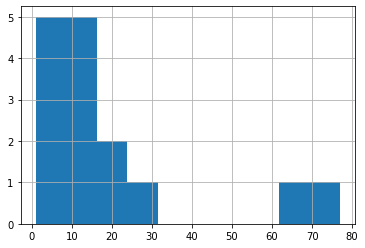

In [147]:
# Which ranks of the market cap are represented?
found_data[found_data['difficulty_factor'] != 0]['#'].hist(bins=10)
plt.show()

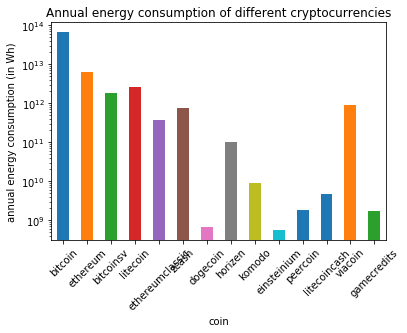

In [148]:
found_data_energy['annual_energy'].plot(kind='bar')
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel('annual energy consumption (in Wh)')
plt.xlabel('coin')
plt.title('Annual energy consumption of different cryptocurrencies')
plt.show()

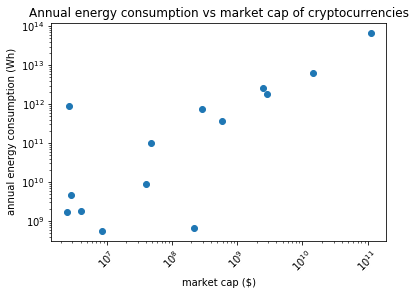

In [149]:
plt.scatter(found_data_energy['market_cap'],found_data_energy['annual_energy'])
plt.yscale('log')
plt.ylabel('annual energy consumption (Wh)')
plt.xscale('log')
plt.xlabel('market cap ($)')
plt.xticks(rotation=45)
plt.title('Annual energy consumption vs market cap of cryptocurrencies')
plt.show()

Linear correlation between market cap and energy consumption with some outliers (e.g. Dogecoin, which uses auxilary POW with litecoin

In [150]:
nethash_calc = found_data[found_data['nethash_calc'] != 0].sort_values(by='algorithm')

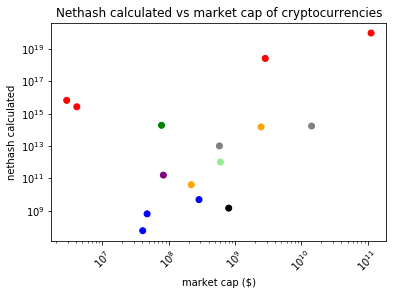

In [151]:
cdict= {'Equihash':'blue', 'Ethash':'grey','Lyra2REv2':'green','RandomX':'black','SHA-256':'red','Scrypt':'orange','X11':'lightgreen','X16Rv2':'purple'}
cmap = nethash_calc['algorithm'].apply(lambda x: cdict[x])
plt.scatter(nethash_calc['market_cap'],nethash_calc['nethash_calc'],c=cmap,label=nethash_calc['algorithm'])
plt.yscale('log')
plt.ylabel('nethash calculated')
plt.xscale('log')
plt.xlabel('market cap ($)')
plt.xticks(rotation=45)
plt.title('Nethash calculated vs market cap of cryptocurrencies')
plt.show()

# Revenue based estimation

Here we calculate an upper bound, assuming all revenues are used to cover the electricity costs

In [152]:
revenue_data = mineable_100[['#','price', 'block_time', 'block_reward']]
revenue_data = revenue_data[~revenue_data.isnull().any(axis=1)].copy()
revenue_data[:4]

,#,price,block_time,block_reward
Name,,,,
bitcoin,1,6157.28,628.0000,12.6816
ethereum,2,129.67,13.2139,2.0000
bitcoinsv,4,155.74,585.0000,12.5000
litecoin,5,38.43,140.0000,12.5000


In [153]:
revenue_data['revenue_per_sec'] = revenue_data['price']*revenue_data['block_reward']/revenue_data['block_time'] 
revenue_data

,#,price,block_time,block_reward,revenue_per_sec
Name,,,,,
bitcoin,1,6157.280000,628.0000,12.681600,124.337838
ethereum,2,129.670000,13.2139,2.000000,19.626303
bitcoinsv,4,155.740000,585.0000,12.500000,3.327778
litecoin,5,38.430000,140.0000,12.500000,3.431250
monero,6,45.970000,110.0000,1.801793,0.752986
dash,9,64.170000,158.0000,1.553313,0.630862
ethereumclassic,10,5.010000,13.0344,3.104000,1.193077
zcash,11,29.890000,75.0000,5.000000,1.992667
dogecoin,12,0.001770,62.0000,10000.000000,0.285484


In [154]:
total_rev_per_sec = np.sum(revenue_data['revenue_per_sec'])
total_rev_per_sec

158.48325188835707

In [155]:
annual_rev = total_rev_per_sec*31536000
annual_rev

4997927831.551229

Currently, the average industrial power rate in China is around US$0.084/KwH – somewhere in the middle when compared to the rest of the world

In [156]:
power_rate = 0.084 #$/KwH

In [157]:
energy = annual_rev/power_rate # in KwH
energy

59499140851.80034

In [158]:
energy_TWh = energy/10**9 # in TwH

In [159]:
energy_TWh/total_energy_world_TWh

0.003050612225789599

# Electronic waste 

In [160]:
# Weight in kg
def hardware_weight(coin): 
    if coin['algorithm'] == 'SHA-256':
        return 4.56
    if coin['algorithm'] == 'Scrypt':
        return 2.5
    if coin['algorithm'] == 'Ethash':
        return 10.5
    if coin['algorithm'] == 'Equihash':
        return 5.500
    return 0

In [161]:
elec_waste = found_data[['#', 'tag', 'algorithm', 'num_hardware']].copy()
elec_waste['weight_hardware'] = elec_waste.apply(lambda x: hardware_weight(x), axis=1)

In [162]:
elec_waste['waste'] = elec_waste['weight_hardware']*elec_waste['num_hardware']/1.5
elec_waste

,#,tag,algorithm,num_hardware,weight_hardware,waste
Name,,,,,,
bitcoin,1,BTC,SHA-256,5.946839e+06,4.56,1.807839e+07
ethereum,2,ETH,Ethash,8.927599e+05,10.50,6.249319e+06
bitcoinsv,4,BSV,SHA-256,1.599372e+05,4.56,4.862090e+05
litecoin,5,LTC,Scrypt,2.979126e+05,2.50,4.965210e+05
monero,6,XMR,RandomX,0.000000e+00,0.00,0.000000e+00
dash,9,DASH,X11,0.000000e+00,0.00,0.000000e+00
ethereumclassic,10,ETC,Ethash,5.279588e+04,10.50,3.695712e+05
zcash,11,ZEC,Equihash,1.147268e+05,5.50,4.206651e+05
dogecoin,12,DOGE,Scrypt,7.951450e+01,2.50,1.325242e+02


# Results

In [ ]:
lower_bounds = []
estimates = []
upper_bounds = []
dates = []
for file in os.listdir(HIST_PATH):
    date = datetime.strptime(file[13:23], '%m-%d-%Y')
    data = pd.read_csv(HIST_PATH+file)
    data = clean_mineable_data(data)
    bounds = hardware_based_estimation(data)
    lower_bound = np.sum(bounds['lower_bound'])*LOWER_PUE
    estimate = np.sum(bounds['estimate'])*ESTIMATE_PUE
    upper_bound = np.sum(bounds['upper_bound'])*UPPER_PUE
    lower_bounds.append(lower_bound)
    estimates.append(estimate)
    upper_bounds.append(upper_bound)
    dates.append(date)

In [ ]:
plt.plot(dates, estimates)
plt.plot(dates, lower_bounds)
plt.plot(dates, upper_bounds)
plt.xticks(rotation=45)
plt.ylabel("Electricity consumption (W)")
plt.xlabel("Date")
plt.show()

In [165]:
found_missing_difficulty[['lower_bound','estimate','upper_bound']]

,lower_bound,estimate,upper_bound
Name,,,
bitcoin,3.758402e+09,6.005190e+09,8.858411e+09
ethereum,2.544366e+08,9.252269e+08,1.304803e+09
bitcoinsv,1.010803e+08,1.615065e+08,2.382424e+08
litecoin,1.433231e+08,1.433231e+08,1.433231e+08
monero,0.000000e+00,0.000000e+00,0.000000e+00
dash,0.000000e+00,0.000000e+00,0.000000e+00
ethereumclassic,1.504683e+07,6.026929e+07,8.359348e+07
zcash,5.061238e+07,7.469352e+07,1.361500e+08
dogecoin,3.825371e+04,1.463959e+07,2.050913e+07


In [166]:
found_missing_difficulty['algorithm'].value_counts()

SHA-256      4
Equihash     3
Ethash       2
Scrypt       2
Lyra2REv2    1
X16Rv2       1
RandomX      1
X11          1
Name: algorithm, dtype: int64